What other tree based regression methods are there in `scikit-learn`?

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [14]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
    y = np.log(train['SalePrice'].values)
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [16]:
# load data
y, X, X_submission, ids_submission = load_data()

In [38]:
parameters = {'n_estimators': [50],
              'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
              'max_depth': [7, 9, 11, 13, 15],
              'min_samples_leaf': [1, 2, 4, 8]}

model = RandomizedSearchCV(ExtraTreesRegressor(random_state=1773, n_jobs=4),
                           parameters, 
                           n_iter=60, 
                           random_state=1773,
                           scoring=make_scorer(rmse, greater_is_better=False), 
                           cv=KFold(10, random_state=1773))

In [39]:
%%time
model.fit(X,y)

CPU times: user 6min 33s, sys: 17.7 s, total: 6min 51s
Wall time: 5min 17s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=1773, shuffle=False),
          error_score='raise',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=4, oob_score=False, random_state=1773,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'n_estimators': [50], 'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 'max_depth': [7, 9, 11, 13, 15], 'min_samples_leaf': [1, 2, 4, 8]},
          pre_dispatch='2*n_jobs', random_state=1773, refit=True,
          return_train_score=True,
          scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [40]:
print 'best score:', model.best_score_
print 'best parameters:', model.best_params_

best score: -0.139182135278
best parameters: {'n_estimators': 50, 'max_features': 0.5, 'max_depth': 15, 'min_samples_leaf': 1}


In [41]:
# create submission predictions
preds_submission = model.predict(X_submission)

# save submission
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(preds_submission)})\
  .to_csv('../output/06_randomsearch_ET.csv', index=False)

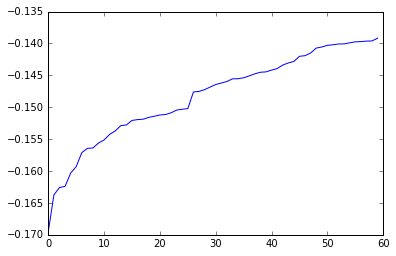

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.sort(model.cv_results_['mean_test_score']));